In [2]:
## Code 

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [17]:
df = pd.read_csv('xy_data.csv')

In [18]:
df.describe()

,x,y
count,1500.000000,1500.000000
mean,83.713931,58.263519
std,13.697157,7.696524
min,59.657204,46.032295
25%,72.282910,51.124211
50%,84.710995,57.681288
75%,93.368257,66.138374
max,109.231520,69.685510


In [6]:
df.isna().sum()

x    0
y    0
dtype: int64

## Visualising the data points

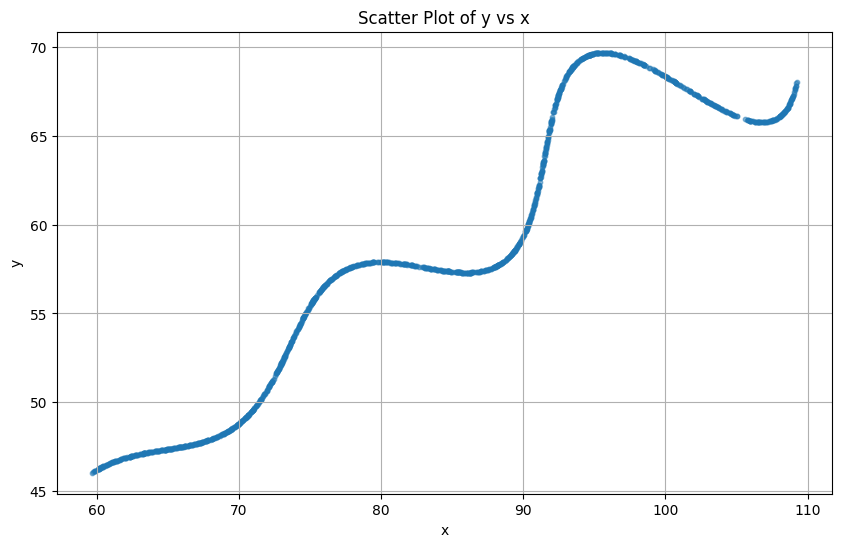

In [32]:
plt.figure(figsize=(10, 6))
plt.scatter(df['x'], df['y'], alpha=0.5, s=10) # alpha set to avoid overcrowding, s for size of points
plt.title('Scatter Plot of y vs x')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()


In [20]:
from scipy.optimize import least_squares, minimize_scalar

### Defining the parametric equation 

In [ ]:
def model(t, theta_deg, M, X):
    theta = np.deg2rad(theta_deg)
    x = t * np.cos(theta) - np.exp(M * np.abs(t)) * np.sin(0.3*t) * np.sin(theta) + X
    y = 42 + t * np.sin(theta) + np.exp(M * np.abs(t)) * np.sin(0.3*t) * np.cos(theta)
    return x, y

### Defining the residual function

In [ ]:
def residuals(p, t_vec, x_obs, y_obs):
    theta_deg, M, X = p
    x_model, y_model = model(t_vec, theta_deg, M, X)
    return np.r_[x_model - x_obs, y_model - y_obs]

### Finding optimal t

In [ ]:
def find_best_t(xk, yk, theta_deg, M, X, t_bounds = (6.0, 60.0)):
    def sq_dist(t):
        xm, ym = model(t, theta_deg, M, X)
        return (xm - xk)**2 + (ym - yk)**2
    res = minimize_scalar(sq_dist, bounds=t_bounds, method='bounded', options={'xatol':1e-3})
    return res.x

### Fitting function

In [ ]:
def alternating_fit(x_obs, y_obs, 
                    init_theta=10.0, init_M=0.0, init_X=10.0,
                    max_iters=1000, tol=1e-6):
    N = len(x_obs)
    # init params
    p = np.array([init_theta, init_M, init_X], dtype=float)

    pts = np.column_stack([x_obs, y_obs])
    '''
    Chord Lengths are used to initialize t values, 
    cause they are a reasonable initial estimate for a starting point
    '''
    dists = np.sqrt(((pts[1:] - pts[:-1])**2).sum(axis=1)) # Chord Lengths
    cum = np.concatenate([[0.0], np.cumsum(dists)]) # Cumulative chord lengths of all points

    # If there's no distance, just space t evenly
    if cum[-1] <= 0:
        t = np.linspace(6.0, 60.0, N)
    else:
        t = 6.0 + (60.0-6.0) * (cum / cum[-1])
    last_obj = np.inf

    # Optimization loop
    for it in range(max_iters):
        # projecting every point to update t_i
        t_new = np.empty_like(t)
        for k, (xk, yk) in enumerate(zip(x_obs, y_obs)): # for each data point, find best t
            t_new[k] = find_best_t(xk, yk, *p, t_bounds=(6.0,60.0))
        #fit params between the bounds provided
        lower = [0.0, -0.05, 0.0]
        upper = [50.0, 0.05, 100.0]

        # calculating the least squares fit
        res = least_squares(residuals, p, bounds=(lower, upper),
                            args=(t_new, x_obs, y_obs), xtol=1e-8, ftol=1e-8)
        p = res.x # update params
        # check objective
        obj_val = 0.5 * np.sum(res.fun**2) # update objective value

        # If converged (based on tolerance), stop iterations
        if abs(last_obj - obj_val) < tol:
            t = t_new
            break
        last_obj = obj_val
        t = t_new
    
    # Return final parameters, t values, and objective value
    return p, t, obj_val

## Modelling the data points

In [ ]:
if {'x','y'}.issubset(df.columns): # check if columns 'x' and 'y' exist
    x_obs = df['x'].to_numpy()
    y_obs = df['y'].to_numpy()
else:
    x_obs = df.iloc[:,0].to_numpy()
    y_obs = df.iloc[:,1].to_numpy()

params, t_est, obj = alternating_fit(x_obs, y_obs, init_theta=10.0, init_M=0.0, init_X=10.0)
print("Fitted (theta_deg, M, X) =", params, "obj=", obj)
print("Estimated t values:", t_est)

Fitted (theta_deg, M, X) = [2.99999012e+01 2.99999313e-02 5.49998883e+01] obj= 9.889281493268114e-06
Estimated t values: [36.78678175 22.90391934  6.70813935 ... 32.40277678  9.81879292
 12.29467202]


## Comparison between observed and fitted points

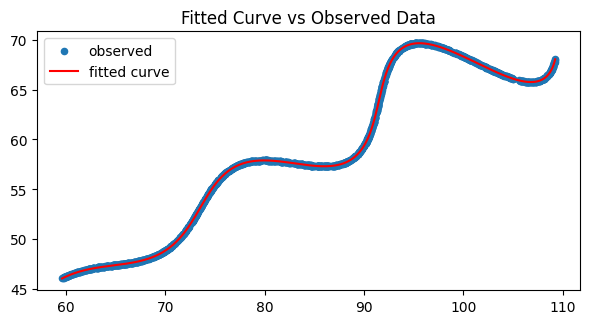

In [ ]:
t_grid = np.linspace(6.0, 60.0, 400)
x_grid, y_grid = model(t_grid, *params)
plt.figure(figsize=(7,5))
plt.scatter(x_obs, y_obs, s=20, label='observed')
plt.plot(x_grid, y_grid, '-r', label='fitted curve')
plt.gca().set_aspect('equal', 'box') # Aspect Ratio
plt.legend()
plt.title('Fitted Curve vs Observed Data')
plt.show()

# Plot the t vs x and t vs y curves


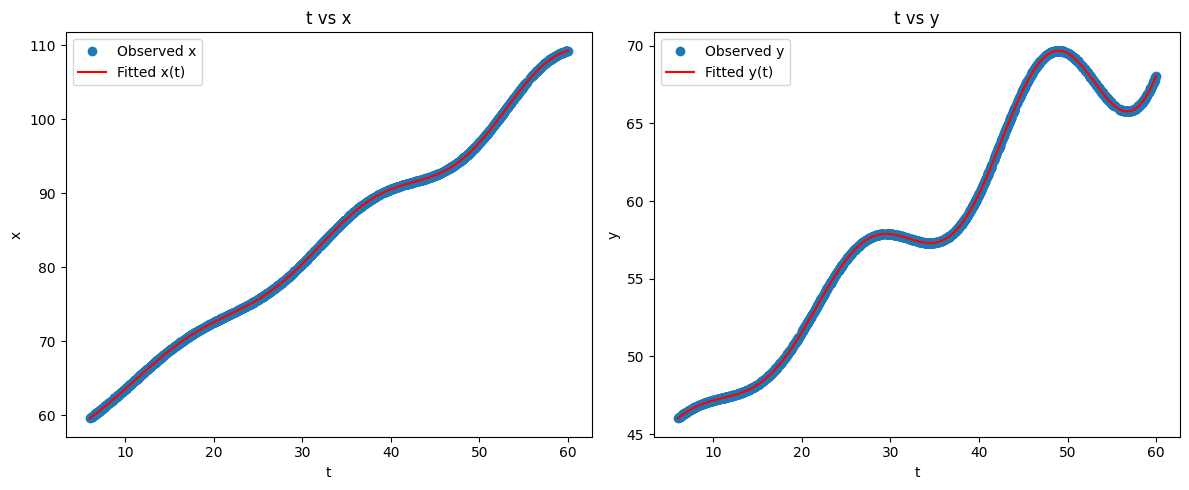

In [43]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(t_est, x_obs, 'o', label='Observed x')
plt.plot(t_grid, x_grid, '-r', label='Fitted x(t)')
plt.xlabel('t')
plt.ylabel('x')
plt.title('t vs x')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(t_est, y_obs, 'o', label='Observed y')
plt.plot(t_grid, y_grid, '-r', label='Fitted y(t)')
plt.xlabel('t')
plt.ylabel('y')
plt.title('t vs y')
plt.legend()
plt.tight_layout()
plt.show()

# Final Parametric Equation

In [39]:
theta_deg, M, X = params
theta_deg, M, X = round(theta_deg, 3), round(M, 3), round(X, 3)

print("Final Parametric Equation:")
print("=" * 50)
print(f"θ = {theta_deg:.3f}°")
print(f"M = {M:.3f}")
print(f"X = {X:.3f}")
print("\nParametric equations:")
print(f"x(t) = t·cos({theta_deg:.3f}°) - exp({M:.3f}·|t|)·sin(0.3t)·sin({theta_deg:.3f}°) + {X:.3f}")
print(f"y(t) = 42 + t·sin({theta_deg:.3f}°) + exp({M:.3f}·|t|)·sin(0.3t)·cos({theta_deg:.3f}°)")
print(f"\nt ∈ [6.0, 60.0]")
print(f"\nResidual objective value: {obj:.6e}")

Final Parametric Equation:
θ = 30.000°
M = 0.030
X = 55.000

Parametric equations:
x(t) = t·cos(30.000°) - exp(0.030·|t|)·sin(0.3t)·sin(30.000°) + 55.000
y(t) = 42 + t·sin(30.000°) + exp(0.030·|t|)·sin(0.3t)·cos(30.000°)

t ∈ [6.0, 60.0]

Residual objective value: 9.889281e-06
